# Assessment of library bottlenecking
There was some concern during Jesse's initial mutational antigenic profiling of this library in 2021 that there may have been library bottlenecking during the low-MOI passaging step. To address this concern, I will perform the following analyses:
1. Correlate the findings for ZKA64 selections from J Virology 2019 paper (aka 'JV-2019') with our findings
2. Scatter plots of amino acid prefs from the average prefs in JV-2019 vs prefs in Goo-library1 (compared to plasmid DNA sequenced by Jackson)

In [19]:
# import packages
import glob
import os
import subprocess
import shutil

import Bio.SeqIO

import dms_tools2
from dms_tools2 import AAS
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as CBPALETTE
import dms_tools2.prefs
import dms_tools2.utils
print(f"Using dms_tools2 {dms_tools2.__version__}")

from IPython.display import display, HTML

import pandas as pd
import altair as alt
from plotnine import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import dms_variants.plotnine_themes

Using dms_tools2 2.6.10


## 1. Correlate ZKA64 findings
We can do this a number of ways, but I think I'll start with plotting differntial selection values for individual mutants and seeing if they correlate between Goo lib1 findings and the JV-2019 overall findings.  

In [20]:
# ignore max rows error from Altair
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [21]:
# identify diffsel samples
compnotebook = '/fh/fast/bloom_j/computational_notebooks/ckikawa/'

jv_ZKA64_meanmutdiffsel = '2022/ZIKV_DMS_with_EvansLab/results/diffsel/summary_ZKA64-meanmutdiffsel.csv'
goo_ZKA64_mutdiffsel = '2022/ZIKV_MAP_GooLab/results/grouped_diffsel/summary_ZKA-64-meanmutdiffsel.csv'

jv_ZKA64_lib1 = '2022/ZIKV_DMS_with_EvansLab/results/diffsel/ZKA64-Lib1_mutdiffsel.csv'
goo_ZKA64_lib1 = '2022/ZIKV_MAP_GooLab/results/grouped_diffsel/ZKA64-ZKA64-lib1_mutdiffsel.csv'

In [22]:
# identify sampleslists of sequencing data that will be used in the amino acid preferences calculation
samplelist = 'data/bottleneck/samplelist.csv'

In [23]:
# identify outdir
resultsdir = 'results/'
datadir = 'data/'

In [24]:
# reference sequences
Erefseq = './data/E.fasta'
subamplicon_alignspecs = './data/subamplicon_alignspecs.txt'

In [25]:
# create dataframes
JV_mean_mutdiffsel = (pd.read_csv(
    os.path.join(compnotebook + jv_ZKA64_meanmutdiffsel))
                      .assign(mut=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'])
                      [['mut','mutdiffsel']]
                      .rename(columns={'mutdiffsel': 'JV_diffsel'})
                     )

Goo_mean_mutdiffsel = (pd.read_csv(
    os.path.join(compnotebook + goo_ZKA64_mutdiffsel))
                     .assign(mut=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'])
                     [['mut','mutdiffsel']]
                     .rename(columns={'mutdiffsel': 'Goo_diffsel'})
                    )

In [9]:
compare_diffsel = JV_mean_mutdiffsel.merge(Goo_mean_mutdiffsel, on='mut')
compare_diffsel = compare_diffsel.dropna()

In [10]:
# not sure if the negative diffsel values are super meaningful to us
# so let's just compare positive diffsel values

compare_diffsel_pos = compare_diffsel[compare_diffsel.JV_diffsel > 0]
compare_diffsel_pos = compare_diffsel_pos[compare_diffsel_pos.Goo_diffsel > 0]

In [11]:
# make directory for diffsel analysis
bottleneck_diffsel_dir = os.path.join(resultsdir + 'bottleneck_diffsel/')
os.makedirs(bottleneck_diffsel_dir, exist_ok = True)

In [11]:
# select point nearest mouse
nearest = alt.selection(type='single', empty='none', nearest=True, on='mouseover')

# create the basic chart
basechart = (
 alt.Chart(compare_diffsel_pos
           .rename(columns={'JV_diffsel': 'JV ZKA64 diffsel',
                            'Goo_diffsel': 'Goo ZKA64 diffsel',
                            'mut': 'mutation'
                            })
           .assign(dummy=0)
           )
 .add_selection(nearest)
 .encode(fill=alt.condition(nearest, alt.value('orange'), alt.value('gray')),
         opacity=alt.condition(nearest, alt.value(1), alt.value(0.4)),
         tooltip=['mutation', 'JV ZKA64 diffsel', 'Goo ZKA64 diffsel'],
         )
 .interactive()
 )

# side-by-side interactive plots to select mutations
chart = (
 basechart.encode(x='JV ZKA64 diffsel:Q',
              y='Goo ZKA64 diffsel:Q'
              )
      .mark_point()
      .properties(width=500,
                  height=500)
 )

# save the interactive plot
plotfile = os.path.join(bottleneck_diffsel_dir, 'select_muts_chart.html')
print(f"Saving interactive plot to {plotfile}")
chart.save(plotfile)

# show the chart
chart 

Saving interactive plot to results/bottleneck_diffsel/select_muts_chart.html


alt.Chart(...)

*This plot will not render in GitHub. Use JavaScript to open in any browser window or Google search for HTML viewers -- c/p the raw HTML file to view.* 

In the above plot, we can see that a number of differentially selected sites are present in both Goo and JV-2019 ZKA-64 differential selection datasets. These are mostly in the sites: Y61, T313, T315 and A333.

In the Goo replicate, some A333 and T335 mutations are differentially selected for that are not present in the JV-2019 replciates. Vice versa, the Goo replicate misses some JV-2019 differentially-selected mutants. 

/home/ckikawa/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


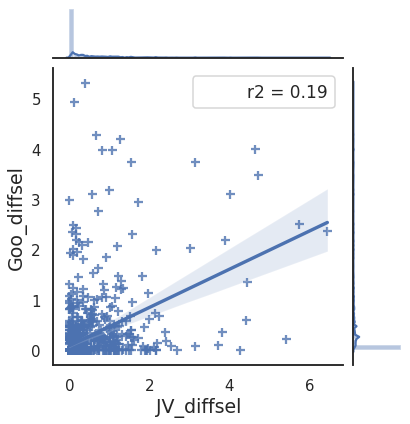

In [12]:
# matplotlib plots
# trying desperately to run a regression since I couldn't get it to work in Altair

%matplotlib inline

x = compare_diffsel_pos.JV_diffsel
y = compare_diffsel_pos.Goo_diffsel

# create a function that returns rsquared (r2) values
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(x, y, marker='+', kind='reg', stat_func = r2)

plt.show()

With differntial selection data I don't think we really expect to see a strong correlation. Most if not all the data I'm showing on this plot is unselected "noise" which will vary widely from replicate-to-replicate. Instead, the finding illustrated better in the Altair plots above (some mutants at sites of interest are enriched in Goo vs. JV-2019 and vice versa; some mutants are enriched in both) is reassuring enough. We do hope/expect to see strong correlation in the amino acid preferences. 

## 2. Amino acid preference plots
My aim is to create scatter plots of amino acid prefs from JV-2019 and Goo lab findings. To do this I will analyze the 3 biological replicate plasmid and virus library sequencing runs from the JV-2019 paper alongside the Goo lab sequencing runs as a quasi-4th replicate. 

In [12]:
samples = (pd.read_csv(samplelist)
           .assign(name=lambda x: x.run + '-' + x.library + '-' + x.selection)
           [['name','library','selection','R1']]
          )
samples.style.hide_index()

name,library,selection,R1
GooCK-Lib1Goo-virus,Lib1Goo,virus,/fh/fast/bloom_j/computational_notebooks/ckikawa/2022/ZIKV_E_DMS_GooLab/data/concat_fastq/concat_fastq_out/lib1_no_antibody_R1.fastq.gz
GooJBS-Lib1Goo-plasmid,Lib1Goo,plasmid,/shared/ngs/illumina/bloom_lab/210115_M04866_0443_000000000-JG3V5/Data/Intensities/BaseCalls/JBS-lib1_S1_L001_R1_001.fastq.gz
GooJBS-Lib2Goo-plasmid,Lib2Goo,plasmid,/shared/ngs/illumina/bloom_lab/210115_M04866_0443_000000000-JG3V5/Data/Intensities/BaseCalls/JBS-lib2_S2_L001_R1_001.fastq.gz
GooJBS-Lib3Goo-plasmid,Lib3Goo,plasmid,/shared/ngs/illumina/bloom_lab/210115_M04866_0443_000000000-JG3V5/Data/Intensities/BaseCalls/JBS-lib3_S3_L001_R1_001.fastq.gz
GooJBS-Lib1Goo-virus,Lib1Goo,virus,/shared/ngs/illumina/bloom_lab/210409_D00300_1210_BHKC7KBCX3/Unaligned/Project_bloom_lab/JBS_38_Sample1_S6_R1_001.fastq.gz
GooJBS-Lib2Goo-virus,Lib2Goo,virus,/shared/ngs/illumina/bloom_lab/210409_D00300_1210_BHKC7KBCX3/Unaligned/Project_bloom_lab/JBS_38_Sample2_S7_R1_001.fastq.gz
GooJBS-Lib3Goo-virus,Lib3Goo,virus,/shared/ngs/illumina/bloom_lab/210409_D00300_1210_BHKC7KBCX3/Unaligned/Project_bloom_lab/JBS_38_Sample3_S8_R1_001.fastq.gz
JV2019-Lib1-plasmid,Lib1,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-1/*R1*.fastq.gz
JV2019-Lib2-plasmid,Lib2,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-2/*R1*.fastq.gz
JV2019-Lib3-plasmid,Lib3,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170609_SN367_0933_BHMLH5BCXY_lane2/Unaligned/Project_bloom_lab/Sample_zikv-3/*R1*.fastq.gz


In [13]:
# read in align specs
with open (subamplicon_alignspecs, 'r') as file:
    alignspecs = file.read().replace('\n','')
alignspecs

'1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35'

In [14]:
# process deep sequencing data: run dms2_batch_subamp
# make folder where codon counts will go
bottleneck_codonsdir = os.path.join(resultsdir + 'bottleneck_codoncounts')
os.makedirs(bottleneck_codonsdir, exist_ok=True)

# tell me if sample path is missing
for c in samples['R1']:
    if c == 'NaN':
       raise ValueError('samples is missing a file path')

# create df and export csv with only name/R1 for dms2_batch_subamp   
batchfile = os.path.join(datadir + 'bottleneck/batchSubampIDs.csv')
samples[['name','R1']].to_csv(batchfile, index=False)

# standard trim in Bloom lab analyses is 200 bp
# from documentation: "removes low-quality nucleotides that tend to be at the end of long reads"
R1TRIM = 200
R2TRIM = 200

#needs a name to run
log = ! dms2_batch_bcsubamp \
    --batchfile {batchfile} \
    --refseq {Erefseq} \
    --alignspecs {alignspecs} \
    --outdir {bottleneck_codonsdir} \
    --summaryprefix summary \
    --R1trim 200 \
    --R2trim 200 \
    --ncpus 16 \
    --use_existing 'yes'

# ! executes following code in the command line

# add column to df.samples that includes filepath to each codoncounts.csv
samples['codoncounts'] = bottleneck_codonsdir + '/' + samples['name'] + '_codoncounts.csv'

# tell me how you did
assert all(map(os.path.isfile, samples.codoncounts)), '\n'.join(log)
print(f'dms2_batch_bcsubamp {dms_tools2.__version__} aligned sequencing data and created codon count files in {bottleneck_codonsdir}')

dms2_batch_bcsubamp 2.6.10 aligned sequencing data and created codon count files in results/bottleneck_codoncounts


In [15]:
JV_samples=samples.drop([0,1,2])
JV_samples

,name,library,selection,R1,codoncounts
3,GooJBS-Lib3Goo-plasmid,Lib3Goo,plasmid,/shared/ngs/illumina/bloom_lab/210115_M04866_0...,results/bottleneck_codoncounts/GooJBS-Lib3Goo-...
4,GooJBS-Lib1Goo-virus,Lib1Goo,virus,/shared/ngs/illumina/bloom_lab/210409_D00300_1...,results/bottleneck_codoncounts/GooJBS-Lib1Goo-...
5,GooJBS-Lib2Goo-virus,Lib2Goo,virus,/shared/ngs/illumina/bloom_lab/210409_D00300_1...,results/bottleneck_codoncounts/GooJBS-Lib2Goo-...
6,GooJBS-Lib3Goo-virus,Lib3Goo,virus,/shared/ngs/illumina/bloom_lab/210409_D00300_1...,results/bottleneck_codoncounts/GooJBS-Lib3Goo-...
7,JV2019-Lib1-plasmid,Lib1,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170...,results/bottleneck_codoncounts/JV2019-Lib1-pla...
8,JV2019-Lib2-plasmid,Lib2,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170...,results/bottleneck_codoncounts/JV2019-Lib2-pla...
9,JV2019-Lib3-plasmid,Lib3,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170...,results/bottleneck_codoncounts/JV2019-Lib3-pla...
10,JV2019-wildtype-plasmid,wildtype,plasmid,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/170...,results/bottleneck_codoncounts/JV2019-wildtype...
11,JV2019-Lib1-virus,Lib1,virus,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,results/bottleneck_codoncounts/JV2019-Lib1-vir...
12,JV2019-Lib2-virus,Lib2,virus,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,results/bottleneck_codoncounts/JV2019-Lib2-vir...


In [16]:
prefs_batch = (
    samples
    .query('library != "wildtype"')
    .query('library != "no-antibody"')
    .query('selection != "plasmid"')
    .assign(post=lambda x: x['name'])
    .assign(newname=lambda x: x['name'].str.slice(stop = -6))
    .merge(samples.query('selection == "plasmid"')
                  .assign(pre=lambda x: x['name'])
                  [['library', 'pre']],
           on=['library'], how='left'
           )
    [['newname', 'selection', 'library', 'pre', 'post']]
    .rename(columns = {'newname': 'name'})
    .assign(errpre='JV2019-wildtype-plasmid')
    .assign(errpost='JV2019-wildtype-virus')     
    )

display(prefs_batch)
assert prefs_batch.notnull().all().all(), "Missing some prefs_batch filenames"

,name,selection,library,pre,post,errpre,errpost
0,GooCK-Lib1Goo,virus,Lib1Goo,GooJBS-Lib1Goo-plasmid,GooCK-Lib1Goo-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus
1,GooJBS-Lib1Goo,virus,Lib1Goo,GooJBS-Lib1Goo-plasmid,GooJBS-Lib1Goo-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus
2,GooJBS-Lib2Goo,virus,Lib2Goo,GooJBS-Lib2Goo-plasmid,GooJBS-Lib2Goo-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus
3,GooJBS-Lib3Goo,virus,Lib3Goo,GooJBS-Lib3Goo-plasmid,GooJBS-Lib3Goo-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus
4,JV2019-Lib1,virus,Lib1,JV2019-Lib1-plasmid,JV2019-Lib1-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus
5,JV2019-Lib2,virus,Lib2,JV2019-Lib2-plasmid,JV2019-Lib2-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus
6,JV2019-Lib3,virus,Lib3,JV2019-Lib3-plasmid,JV2019-Lib3-virus,JV2019-wildtype-plasmid,JV2019-wildtype-virus


Now we can run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html)...

## `method bayesian` vs. `method ratio`
As a side note, in re-doing some of this analysis I see a pretty large difference in correlation R values when I calculate amino acid preferences with `method bayesian` vs. `method ratio`. The JV-2019 paper used the Bayesian method. Initially I used ratio, which lead to some confusion as to why I couldn't replicate their published R values when doing my amino acid preferences correlation. 

When calculated with __Bayesian method__, the R values are in the 0.6-0.7 range, shown below.

In [ ]:
prefsdir = os.path.join(resultsdir, 'bottleneck_prefs')
os.makedirs(prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {bottleneck_codonsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --method bayesian \
        --use_existing 'no'\
        --ncpus 16

assert all(map(os.path.isfile, [os.path.join(prefsdir, name + '_prefs.csv') 
                                for name in prefs_batch.name])), '\n'.join(log)

print("Amino-acid preferences calculated for all samples.")

Look at correlation among the amino-acid preferences for the individual libraries:

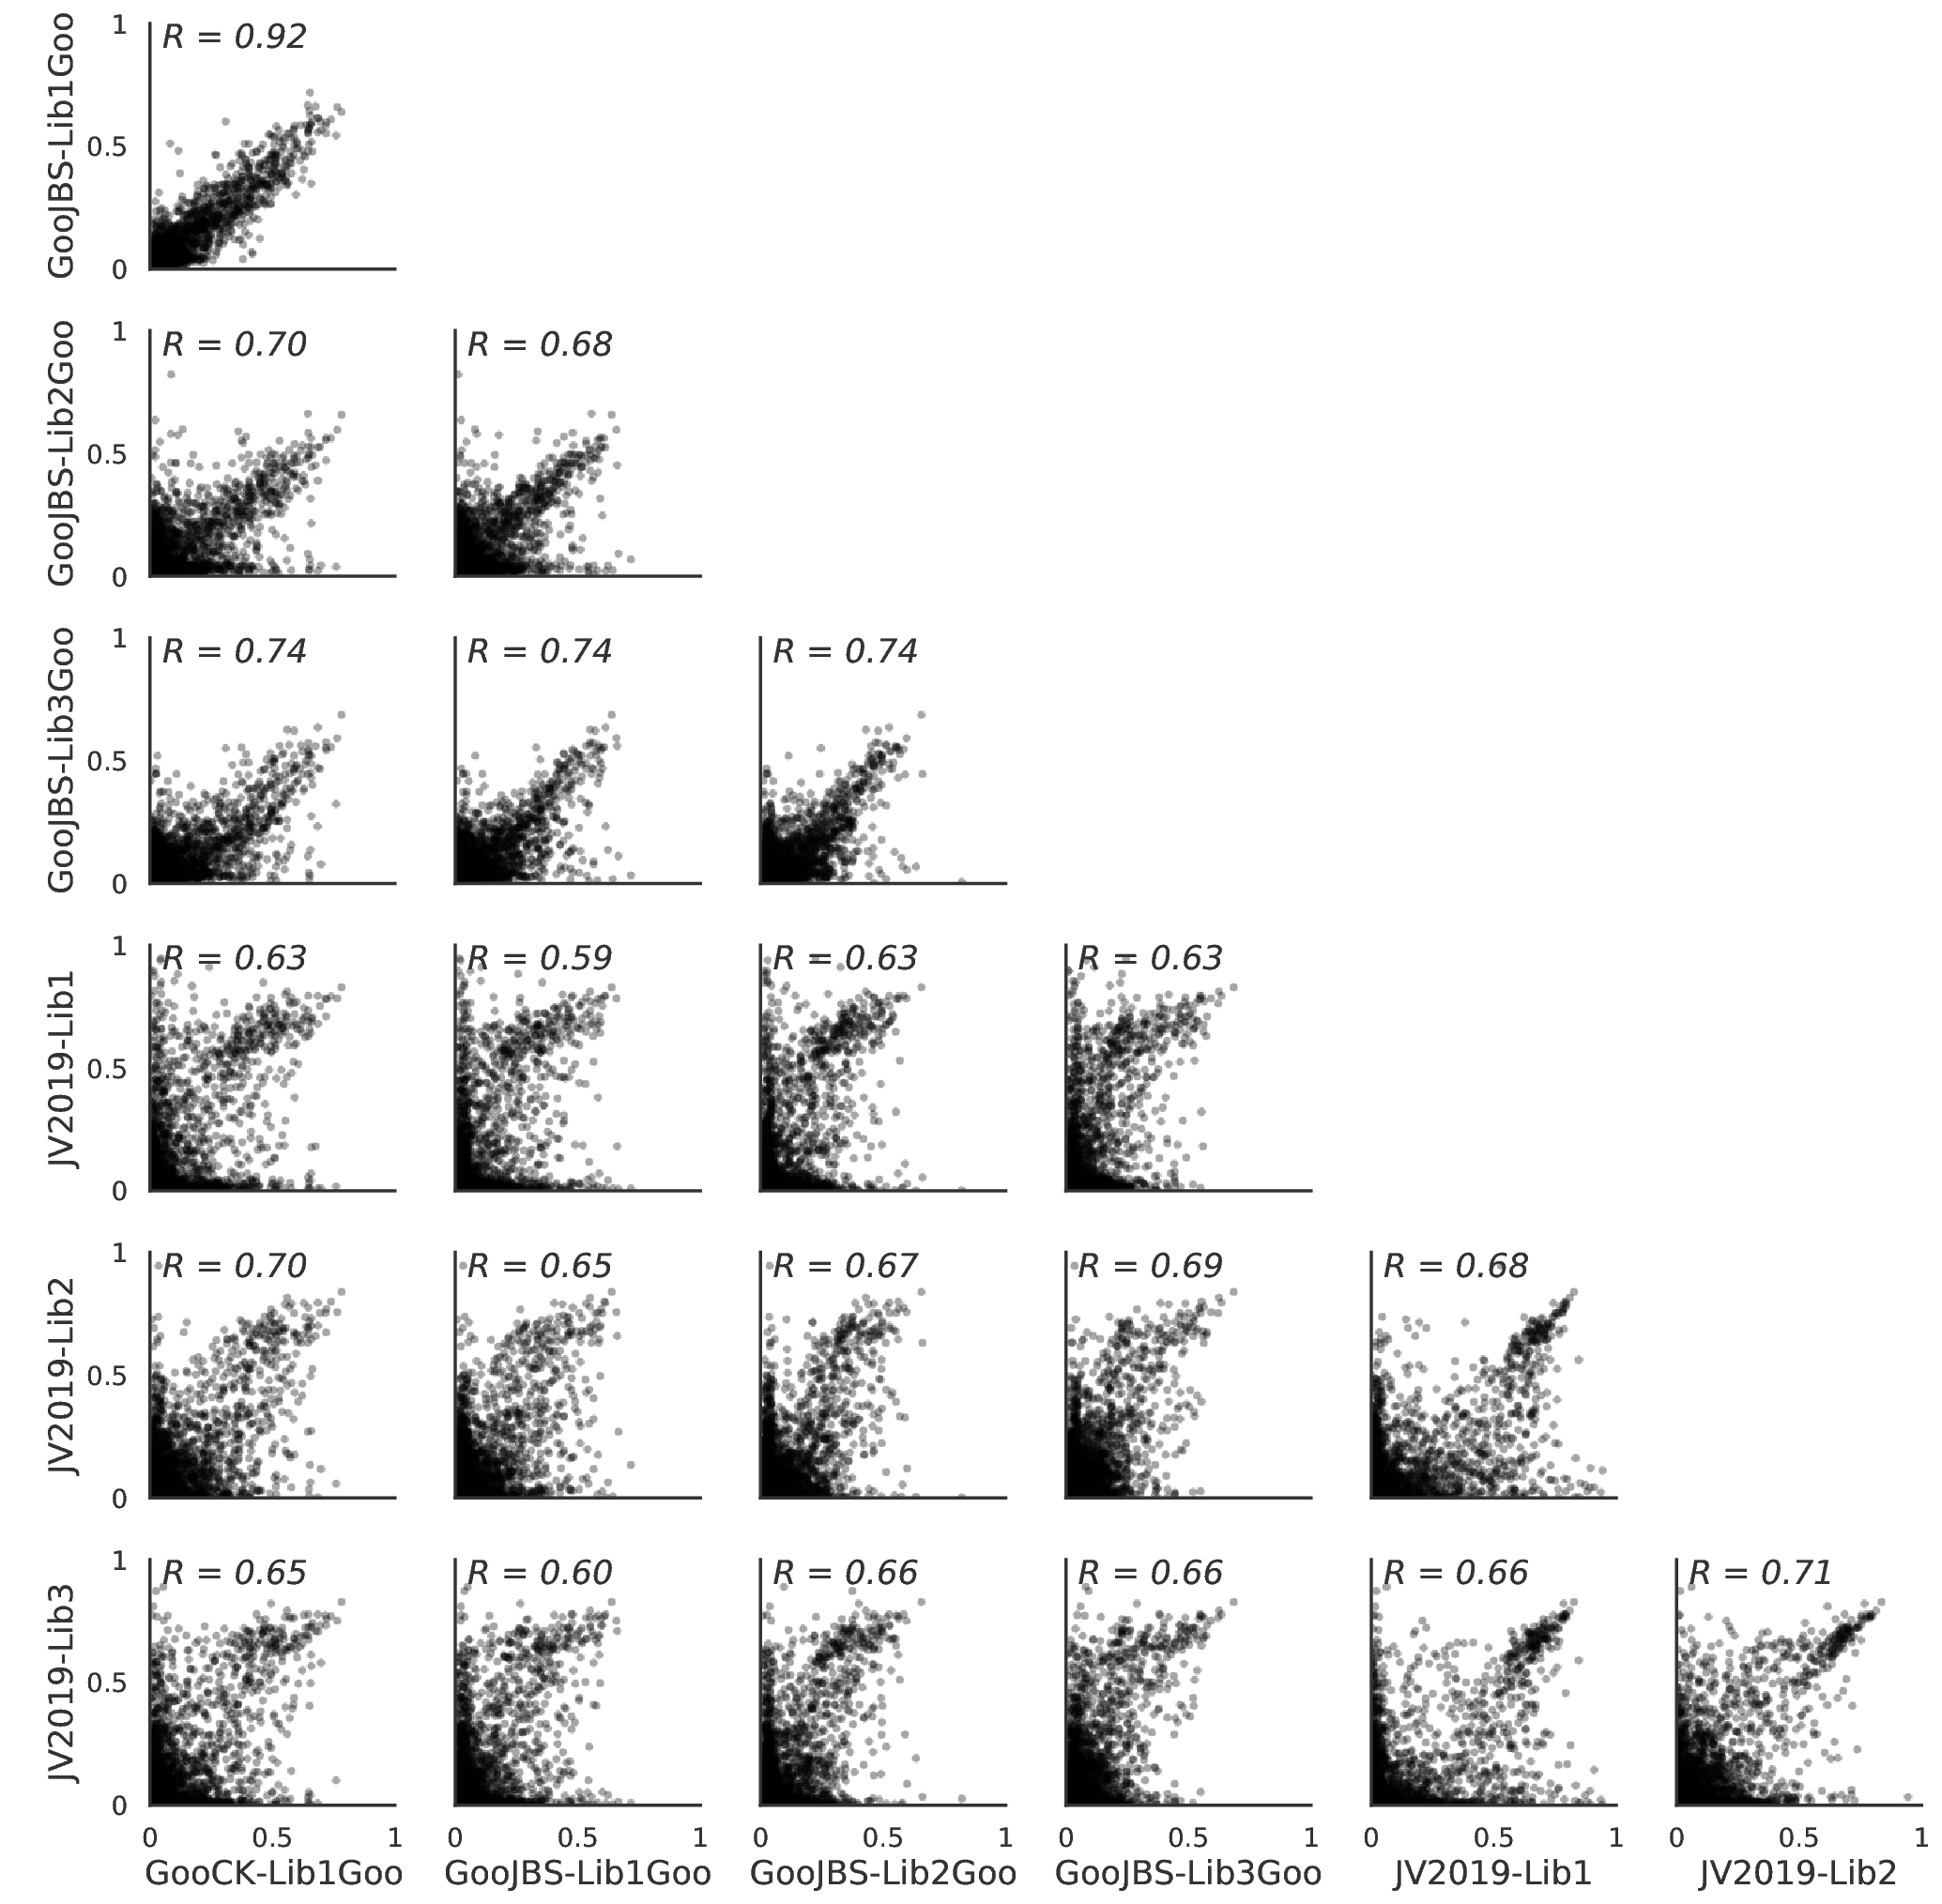

In [26]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'), width = 600)

Based on the above graph, the JV-2019 libraries (*Lib1-Lib3*) correlate with eachother with __R = 0.66-0.71__

I am showing 2 versions of the Goo mutatnt library 1. The Goo library from one of my unselected samples (*Lib1Goo-no-antibody*) from a recent library prep sequencing run correlates about that strongly with JV-2019 libraries, with __R range = 0.63-0.70__

The other version of Goo mutant library 1 is the low-MOI passaged virus (*Lib1Goo-virus*) that was prepped and sequneced by Jackson in 2021. This library correlates even less strongly with JV-2019 viruses, with __R range = 0.59-0.65__


When calculated with __ratio method__, the R values are in the 0.3-0.5 range, shown below.

Amino-acid preferences calculated for all samples.


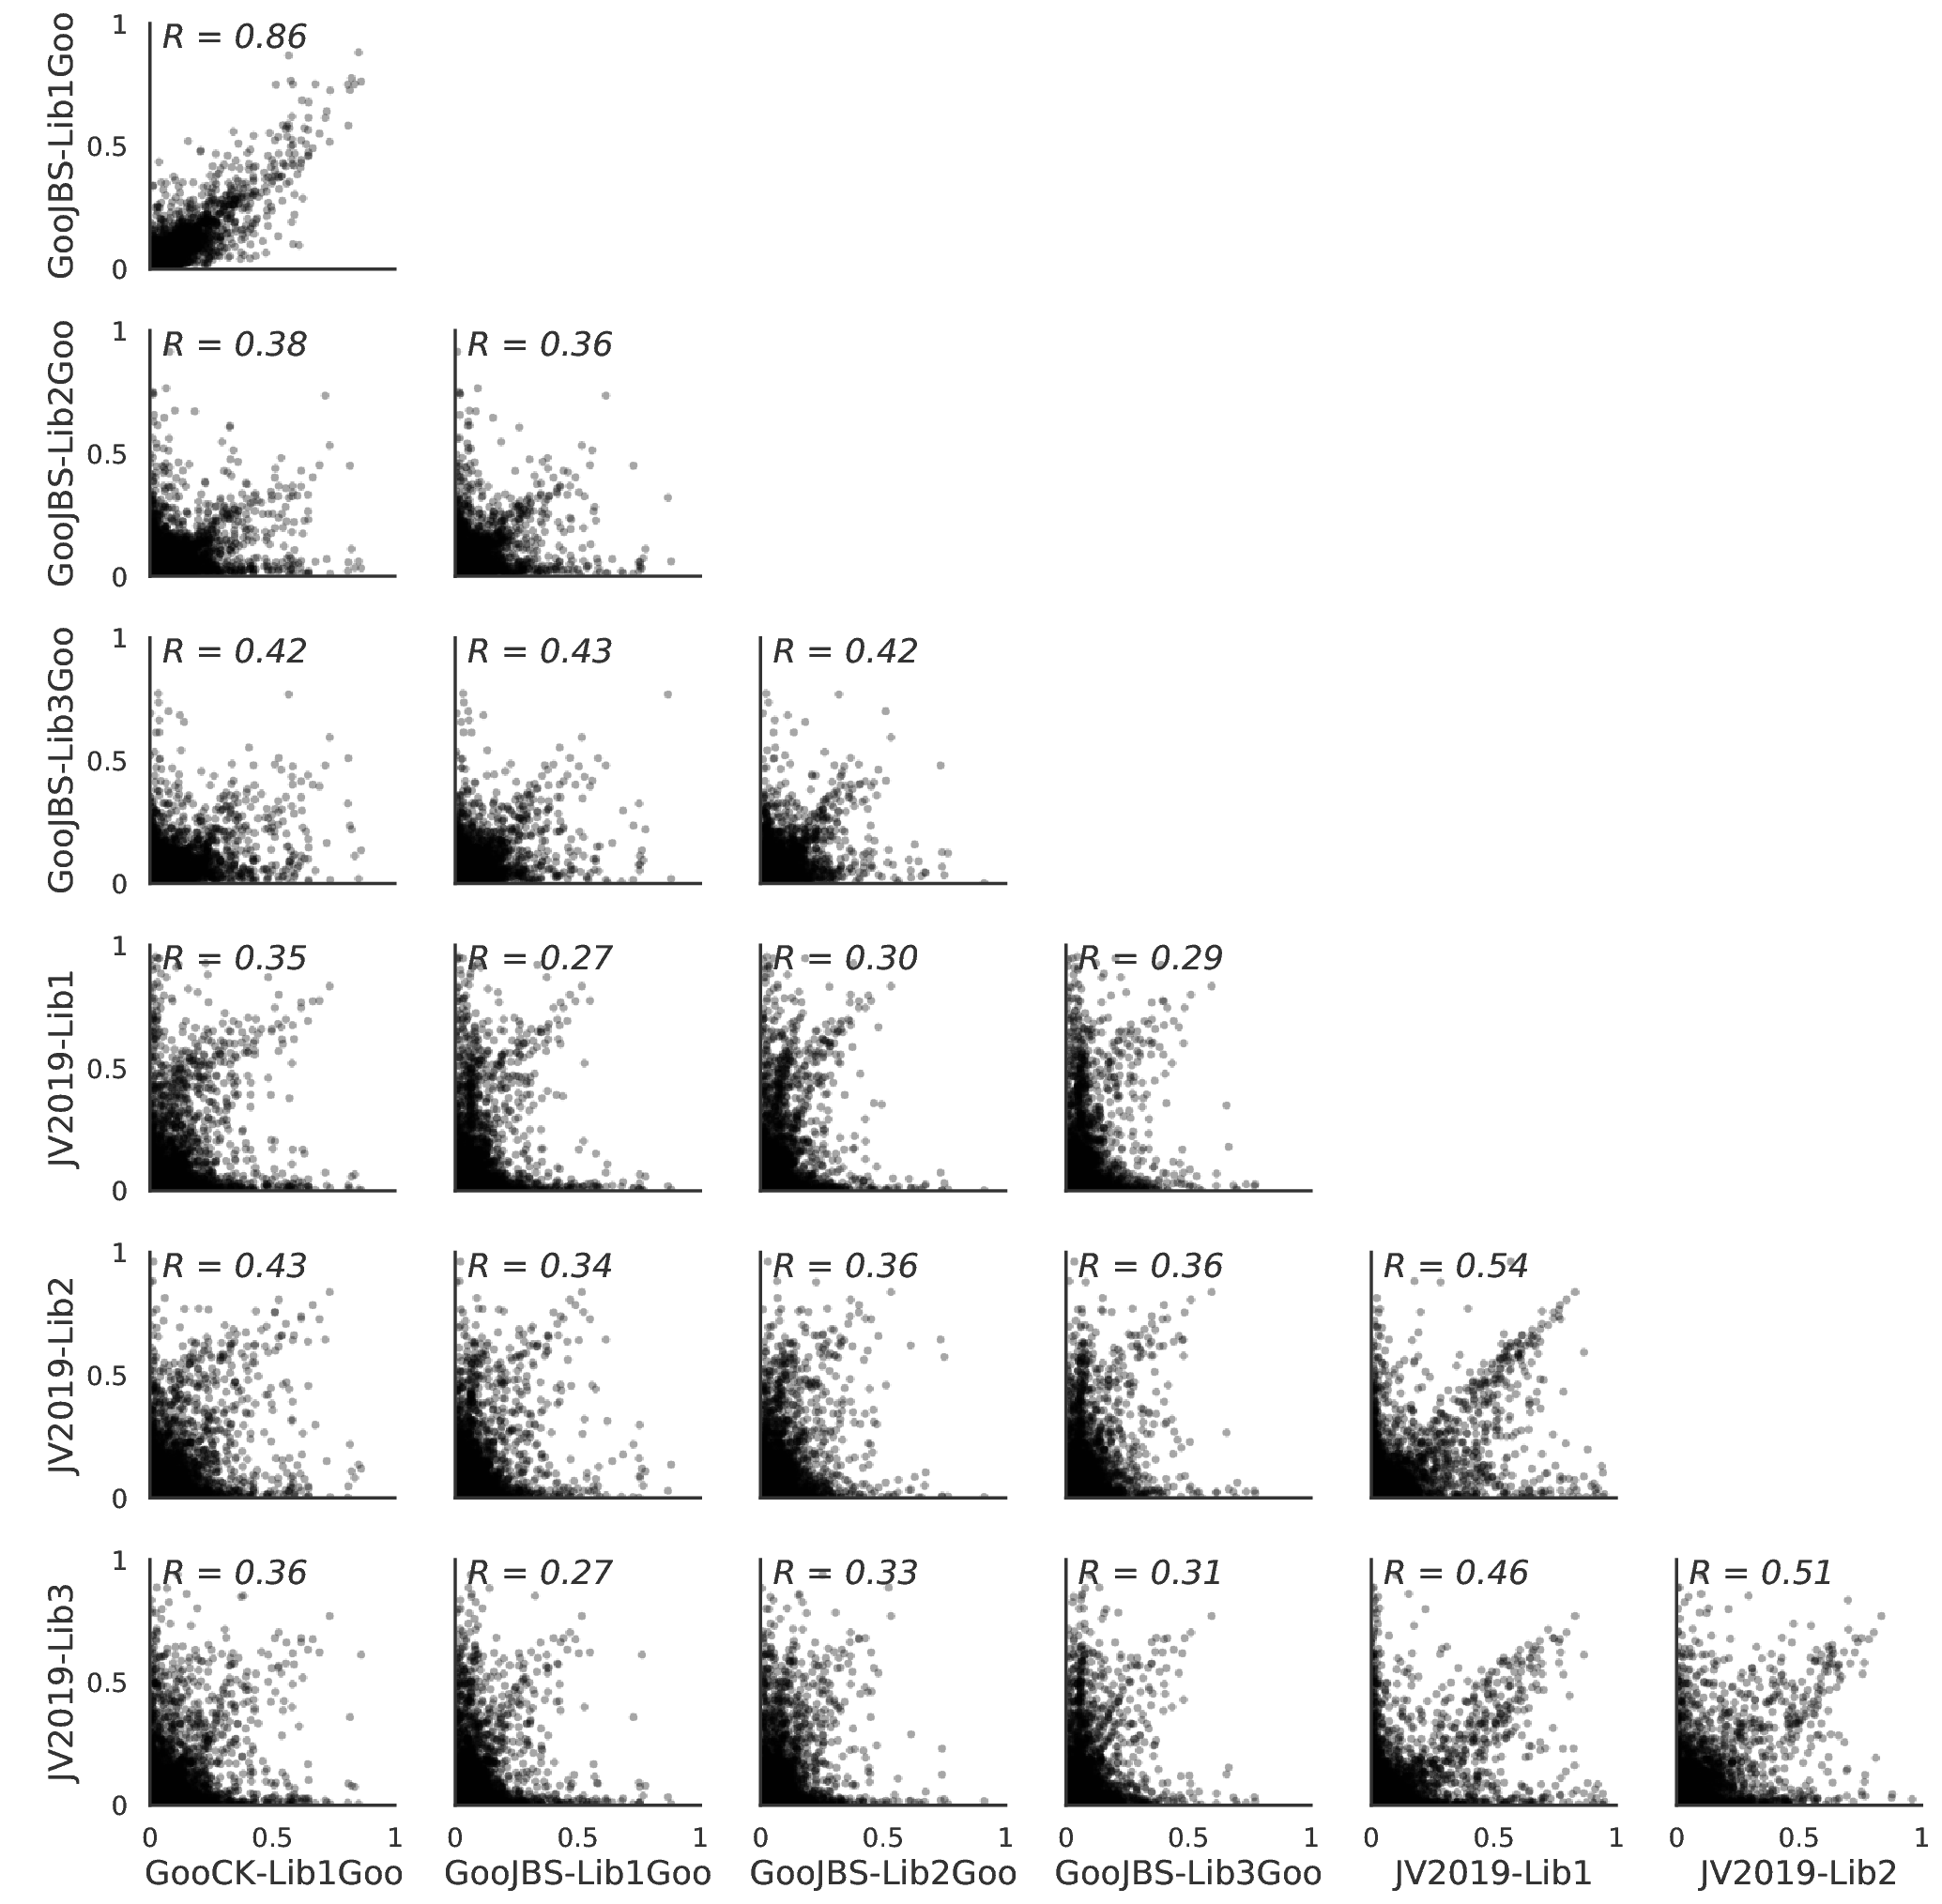

In [20]:
ratio_prefsdir = os.path.join(resultsdir, 'bottleneck_prefs_ratio')
os.makedirs(ratio_prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(ratio_prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {bottleneck_codonsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {ratio_prefsdir} \
        --summaryprefix summary \
        --method ratio \
        --use_existing 'no'\
        --ncpus 16

assert all(map(os.path.isfile, [os.path.join(ratio_prefsdir, name + '_prefs.csv') 
                                for name in prefs_batch.name])), '\n'.join(log)

print("Amino-acid preferences calculated for all samples.")

showPDF(os.path.join(ratio_prefsdir, 'summary_prefscorr.pdf'), width = 600)